In [1]:
import models
import os
from data_loader import BSDS_RCFLoader
#from torch.utils.data import DataLoader
from fastai2.vision.all import *
from pathlib import Path
import gc
from scipy import io as scio
#import cv2
Path.ls = lambda x: list(x.iterdir())

In [2]:
cuda = torch.cuda.is_available(); cuda

False

# HED-BSDS-PASCAL dataset

In [3]:
p = Path().absolute().home()/'Datasets/HED-BSDS_PASCAL'
p.ls()

[Path('/Users/antoninsumner/Datasets/HED-BSDS_PASCAL/PASCAL'),
 Path('/Users/antoninsumner/Datasets/HED-BSDS_PASCAL/.DS_Store'),
 Path('/Users/antoninsumner/Datasets/HED-BSDS_PASCAL/HED-BSDS'),
 Path('/Users/antoninsumner/Datasets/HED-BSDS_PASCAL/bsds_pascal_train_pair.lst')]

In [55]:
main_dataset = BSDS_RCFLoader(root=str(p), split="train", size=32)

In [56]:
n = len(main_dataset);n

49006

In [57]:
bs = 16 if cuda else 3

blocks = (DataBlock(#blocks = (ImageBlock, ImageBlock(cls=PILImageBW)),
                    splitter=    IndexSplitter(range(n//5)),
                    get_x=       lambda i: main_dataset[i][0],
                    get_y=       lambda i: main_dataset[i][1],
                    #item_tfms=   [RandomResizedCrop(256 if cuda else 256), FlipItem()],
                    )#batch_tfms = [*aug_transforms()])
          )

In [58]:
dls = blocks.dataloaders(range(n), bs=bs, device='cuda' if cuda else 'cpu', num_workers=0)

In [59]:
x,y = dls.one_batch()

In [60]:
x.shape, x.min(), x.max()

(torch.Size([3, 3, 32, 32]), tensor(0.), tensor(1.))

In [61]:
y.shape, y.min(), y.max()

(torch.Size([3, 1, 32, 32]), tensor(0.), tensor(1.))

In [52]:
def show_preds(m, dls):
    batch, targ = dls.one_batch()
    y = m(batch)[-1]
    n = batch.shape[0]
    fig, ax = plt.subplots(nrows=n, ncols=3, figsize=(5*3, 5*n))
    for i in range(n):
        ax[i][0].imshow(batch[i].permute(1,2,0))
        pred = y[i,0,...].detach().numpy()
        ax[i][1].imshow(pred, cmap='gray')
        ax[i][2].imshow(targ[i,0], cmap='gray')

# BSDS Dataset

In [3]:
p = Path().absolute().home()/'Datasets/BSDS/BSDS500/data/images'
p.exists()

True

## Manage .mat files

In [12]:
def get_rand_edges(fn):
    
    """ Take an image filename and get's it's ground truth
    Ground truth it accumulated and normalized on [0,1] scale
    then multiplied by 255 to match dataloader behavior"""
    
    res = Path(fn).parent.parent.parent/'groundTruth'/fn.relative_to(fn.parent.parent).parent/(str(fn.stem)+'.mat')
    assert res.exists(), "File does not exist"
    mat = scio.loadmat(str(res))
    e = mat['groundTruth']
    n = len(e[0])
    s = np.random.randint(1,n)
    res = np.array([e[0][idx][0][0][1] for idx in np.random.choice(range(n),size=s)])
    res = res.sum(axis=0)
    res = (res - res.min()) / (res.max()-res.min())
    res = res*255
    return res

## File getters

In [5]:
#export
def _get_files(p, fs, extensions=None):
    p = Path(p)
    res = [p/f for f in fs if not f.startswith('.')
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res

In [6]:
#export
def get_files_subset(path, extensions=None, recurse=True, folders=None, followlinks=True, pct = 1., check_cls=False):
    "Get all the files in `path` with optional `extensions`, optionally with `recurse`, only in `folders`, if specified."
    path = Path(path)
    folders=L(folders)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for i,(p,d,f) in enumerate(os.walk(path, followlinks=followlinks)): # returns (dirpath, dirnames, filenames)
            if len(folders) !=0 and i==0: d[:] = [o for o in d if o in folders]
            else:                         d[:] = [o for o in d if not o.startswith('.')]
            if len(folders) !=0 and i==0 and '.' not in folders: continue
            res += _get_files(p, f, extensions)
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        res = _get_files(path, f, extensions)
        
    def _class_distrib(fns):
        t_counts = np.unique([p.parent.name for p in fns if p.parent.parent.name=='train'], return_counts=True)[1]
        v_counts = np.unique([p.parent.name for p in fns if p.parent.parent.name=='val'], return_counts=True)[1]
        t_counts = t_counts / t_counts.sum()
        v_counts = v_counts / v_counts.sum()
        return np.append(t_counts, v_counts)
    
    if pct and pct != 0:
        n = int(len(res)*pct)
        if check_cls:
            ## Find the subset with best class distribution
            d = _class_distrib(res)
            ssets = {}
            for _ in range(20):
                for i in range(5):
                    ss = np.random.choice(res, size=n, replace=False)
                    d2 = _class_distrib(ss)
                    if len(d) == len(d2): break
                    assert i == 4, "Could not find subset with good class distribution. Increase pct."
                dist = (d - d2).std()
                ssets[dist] = ss
            res = ssets[min(ssets.keys())]
        else:
            res = np.random.choice(res, size=n, replace=False)

    return L(*res)

In [7]:
#export
def ParentSplitter(train_name='train', valid_name='val'):
    def _inner(o, **kwargs):
        train = [ i for i in range(len(o)) if Path(o[i]).parent.name == train_name]
        valid = [ i for i in range(len(o)) if Path(o[i]).parent.name == valid_name]
        return train, valid
    return _inner

## DataLoaders

In [13]:
bs = 16 if cuda else 3

blocks = (DataBlock(blocks = (ImageBlock, ImageBlock(cls=PILImageBW)),
                    get_items=   partial(get_files_subset, extensions=['.jpg'], folders=['train','val'], pct=1. if cuda else 1.),
                    splitter=    ParentSplitter(),
                    get_y=       get_rand_edges,
                    item_tfms=   [RandomResizedCrop(256 if cuda else 256), FlipItem()],
                    batch_tfms = [*aug_transforms()])
          )

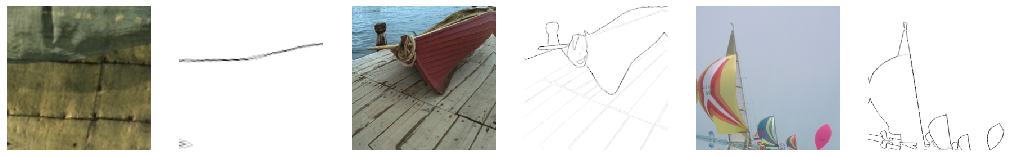

In [14]:
dls = blocks.dataloaders(p, bs=bs, device='cuda' if cuda else 'cpu', num_workers=0)
dls.show_batch()

In [16]:
#out_dir = (Path()/'samples').absolute()
#assert out_dir.exists()

#test_fs = sorted(get_files_subset(p , extensions=['.jpg'], folders=['test'], pct=1.))
#test_dl = dls.test_dl(test_fs[-3:])
#test_dl.show_batch()

In [17]:
def show_step_preds(m, dls):
    batch, targ = dls.one_batch()
    y = m(batch)
    n = batch.shape[0]
    m = len(y)
    fig, ax = plt.subplots(nrows=n, ncols=m+1, figsize=(5*(2+m), 5*n))
    for i in range(n):
        ax[i][0].imshow(batch[i].permute(1,2,0))
        for j in range(m):
            pred = y[j][i,0,...].detach().numpy()
            ax[i][j+1].imshow(pred, cmap='gray')
        ax[i][-1].imshow(targ[i,0], cmap='gray')

# Metrics

## Crisp Loss (inversed Dice score + BCEL)

In [11]:
def inv_dice_loss(pred, targ):
    eps = 1e-7
    p = pred.view(-1)
    t = targ.view(-1)
    res = (p**2).sum() + (t**2).sum() + eps
    res /= 2 * (p*t).sum() + eps
    return res

In [29]:
def crisp_loss(pred,targ, a=1., b=.001):
    pred = pred[-1]
    CE_loss = F.binary_cross_entropy(pred, targ)
    D_loss = inv_dice_loss(pred,targ)
    loss = a * D_loss + b * CE_loss
    return loss

In [13]:
fake_pred = torch.rand(8,1,64,64)
fake_target = torch.from_numpy(np.random.choice(np.linspace(0,1,num=5), size = 8*64*64)).view(8,1,64,64).to(torch.float32)

In [14]:
inv_dice_loss(fake_pred, fake_target)

tensor(1.4137)

In [15]:
crisp_loss(fake_pred, fake_target)

tensor(1.4147)

## F1_Score

In [16]:
def get_precision(pred,targ):
    eps = 1e-7
    tp = (pred*targ).sum()
    fp = (pred*(1-targ)).sum()
    return tp / (tp + fp + eps)

In [17]:
def get_recall(pred,targ):
    eps = 1e-7
    tp = (pred*targ).sum()
    fn = ((1-pred)*targ).sum()
    return tp / (tp + fn + eps)

In [18]:
def f1_score(pred,targ):
    eps = 1e-7
    precision = get_precision(pred,targ)
    recall = get_recall(pred,targ)
    
    f1 = (2*precision*recall)/(precision+recall+eps)
    return f1

In [19]:
f1_score(fake_pred, fake_target)

tensor(0.5026)

## Quantitative Scores

### Binary pred

In [20]:
def binary_pred(pred, thresh=.5):
    b = pred.clone().detach()
    b[b < thresh] = 0
    b[b >= thresh] = 1
    return b

### ODS

In [21]:
def ods(preds, targ, return_all=False):
    p = torch.sigmoid(preds[-1])
    scores = { f1_score(binary_pred(p,thresh=t), targ) : t  for t in np.linspace(0.,1.,num=100)}
    best_score = max(scores.keys())
    best_thresh = scores[best_score]
    if return_all: return best_score, best_thresh, scores
    else: return best_score

# RCF Model

In [62]:
model = models.resnet101(pretrained=True)
if cuda: model = model.cuda()

In [63]:
l = Learner(dls, model, loss_func=crisp_loss)

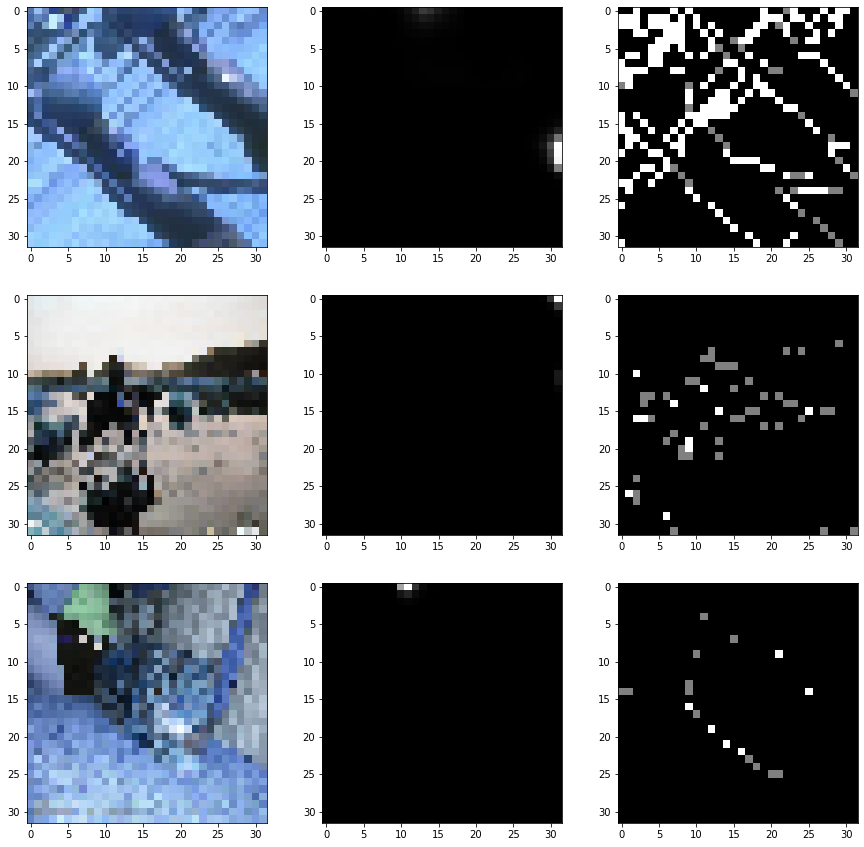

In [64]:
show_preds(model, dls)

In [65]:
l.fit_one_cycle(100 if cuda else 1, lr=1e-2, wd=1e-4)

KeyboardInterrupt: 